## README

### Useful Commands

#### Build

cd ~/ros2_ws

colcon build --packages-select sjtu_drone_description --parallel-workers 1 --executor sequential

colcon build --packages-select sjtu_drone_description --parallel-workers 1 --executor sequential --cmake-args -DBUILD_TESTING=OFF

source install/setup.bash

source ~/ros2_ws/install/setup.bash

echo "source ~/ros2_ws/install/setup.bash" >> ~/.bashrc

#### Clean Build/Install

rm -rf build/sjtu_drone_description install/sjtu_drone_description log/latest_build

#### Drone Launch

ros2 launch sjtu_drone_description single_drone.launch.py

#### Takeoff
ros2 topic pub --once /drone1/takeoff std_msgs/msg/Empty

#### Control with Keyboard
ros2 run teleop_twist_keyboard teleop_twist_keyboard --ros-args --remap cmd_vel:=/drone1/cmd_vel

#### Land
ros2 topic pub --once /drone1/land std_msgs/msg/Empty

### Voice Control Commands

#### Terminal 1: Launch simulation

ros2 launch sjtu_drone_description single_drone.launch.py

#### Terminal 2: Start commander

ros2 run sjtu_drone_description drone_commander_node.py

OR

python3 ~/ros2_ws/src/sjtu_drone_description/scripts/drone_commander_node.py

#### Terminal 3: Start parser

ros2 run sjtu_drone_description intent_parser_node.py

OR

python3 ~/ros2_ws/src/sjtu_drone_description/scripts/intent_parser_node.py

#### Terminal 4: Voice/Audio/Keyboard input

ros2 run sjtu_drone_description stt_node.py

python3 ~/ros2_ws/src/sjtu_drone_description/scripts/stt_node.py

then type (speak)

## Nodes Architecture

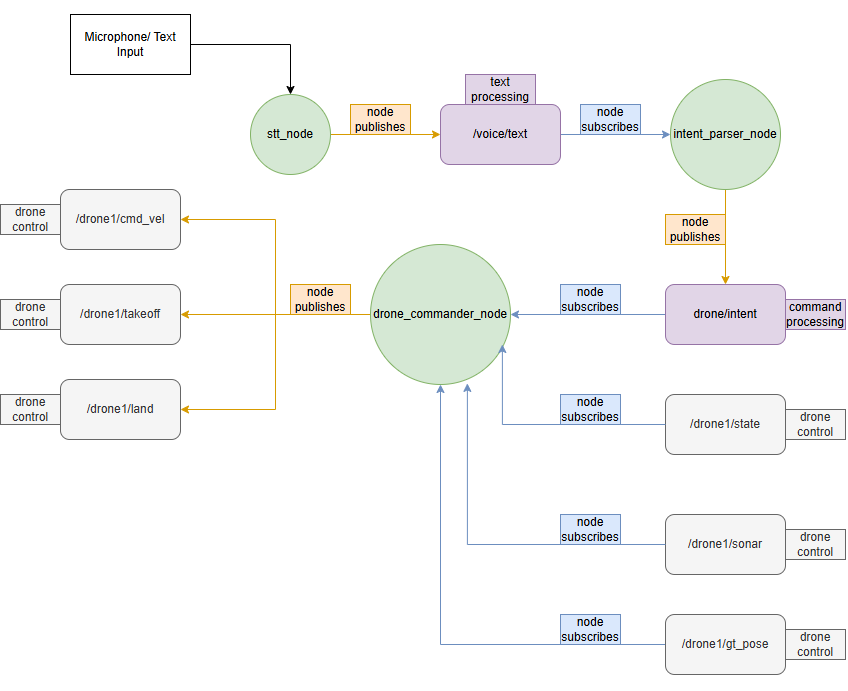

### Custom Nodes (Voice Control System)

Pre-recorded audio files or text input simulation.
Using STT Whisper Tiny Model

---

#### Node 1: **stt_node** (Speech-to-Text)
**File:** `scripts/stt_node.py`

**Purpose:** Convert audio/voice to text commands

**Subscribes to:**
- (Optional) `/audio/input` if using microphone simulation

**Publishes to:**
- `/voice/text` (std_msgs/String) - Recognized text

**Rate:** Variable (on voice activity detection)

---

#### Node 2: **intent_parser_node**
**File:** `scripts/intent_parser_node.py`

**Purpose:** Parse text into structured drone commands

**Subscribes to:**
- `/voice/text` (std_msgs/String) - Raw voice text

**Publishes to:**
- `/drone/intent` (std_msgs/String) - Structured command JSON
  - Format: `{"action": "move", "direction": "forward", "distance": 2.0}`

**Implementation:**
- Simple keyword matching: "takeoff" → `{"action": "takeoff"}`
- Parse directions: "move forward 2 meters" → extract direction + distance
- Error handling for ambiguous commands

**Rate:** On message arrival

---

#### Node 3: **drone_commander_node**

**File:** `scripts/drone_commander_node.py`

**Purpose:** Execute commands and ensure safe operation

**Subscribes to:**
- `/drone/intent` (std_msgs/String) - Parsed commands
- `/drone1/state` (std_msgs/Int8) - Current drone state
- `/drone1/sonar` (sensor_msgs/Range) - Ground distance for safety
- `/drone1/front/gt_pose` for obstacle detection

**Publishes to:**
- `/drone1/cmd_vel` (geometry_msgs/Twist) - Velocity commands
- `/drone1/takeoff` (std_msgs/Empty) - Takeoff trigger
- `/drone1/land` (std_msgs/Empty) - Land trigger
- (Optional) `/voice/feedback` (std_msgs/String) - Status messages ("Taking off...", "Landing complete")

**Implementation:**
- State machine: only accept commands when drone is FLYING (state=1)
- Safety checks: altitude limits, velocity limits
- Command execution with timeout
- Obstacle avoidance (if using camera/sonar)

**Rate:** 10Hz control loop

### System Nodes (Already Part of Setup)

#### 1. **gazebo (gzserver + gzclient)**
- **Type:** Gazebo Simulation Engine
- **Purpose:** Runs the physics simulation and renders the 3D world
- **Publishes:** 
  - `/clock` (rosgraph_msgs/Clock) - Simulation time
  - Various internal Gazebo topics
- **Subscribes:** Model state updates from plugins

#### 2. **robot_state_publisher**
- **Type:** ROS2 Node (C++)
- **Purpose:** Publishes TF transforms for all robot links defined in URDF
- **Publishes:**
  - `/tf` (tf2_msgs/TFMessage) - Transform tree
  - `/tf_static` (tf2_msgs/TFMessage) - Static transforms
  - `/robot_description` (std_msgs/String) - URDF as string
- **Subscribes:**
  - `/joint_states` (sensor_msgs/JointState) - Joint positions (none in our case, drone has no joints)
- **Rate:** Publishes transforms at ~30Hz

#### 3. **spawn_entity.py**
- **Type:** Python script (ros2 run gazebo_ros spawn_entity.py)
- **Purpose:** Spawns the drone URDF into Gazebo simulation
- **Action:** Runs once at startup, then exits
- **Calls Service:** `/spawn_entity` (gazebo_msgs/srv/SpawnEntity)

#### 4. **libplugin_drone.so (Gazebo Plugin - runs inside Gazebo)**
- **Type:** C++ Gazebo Model Plugin
- **Purpose:** Implements quadcopter flight dynamics, PID control, and sensor integration
- **Subscribes to:**
  - `/drone1/cmd_vel` (geometry_msgs/Twist) - Velocity commands
  - `/drone1/takeoff` (std_msgs/Empty) - Takeoff trigger
  - `/drone1/land` (std_msgs/Empty) - Land trigger
  - `/drone1/reset` (std_msgs/Empty) - Reset state
  - `/drone1/posctrl` (std_msgs/Bool) - Enable position control mode
  - `/drone1/dronevel_mode` (std_msgs/Bool) - Switch velocity/tilt mode
  - `/drone1/imu` (sensor_msgs/Imu) - IMU feedback (internal loop)
- **Publishes:**
  - `/drone1/imu` (sensor_msgs/Imu) @ 100Hz - Orientation, angular velocity
  - `/drone1/sonar` (sensor_msgs/Range) @ 30Hz - Ground distance
  - `/drone1/front/image_raw` (sensor_msgs/Image) @ 30Hz - Camera feed
  - `/drone1/front/camera_info` (sensor_msgs/CameraInfo) @ 30Hz - Camera calibration
  - `/drone1/odom` (nav_msgs/Odometry) @ 30Hz - Position & velocity with TF
  - `/drone1/gt_pose` (geometry_msgs/Pose) - Ground truth pose
  - `/drone1/gt_vel` (geometry_msgs/Twist) - Ground truth velocity (body frame)
  - `/drone1/gt_acc` (geometry_msgs/Twist) - Ground truth acceleration
  - `/drone1/state` (std_msgs/Int8) - Drone state (0=Landed, 1=Flying, 2=TakingOff, 3=Landing)
- **TF Broadcasts:**
  - `/drone1/odom` → `/drone1/base_footprint`
- **Control Loop:** Runs at simulation rate (~1000Hz internally, updates physics each step)

### Complete Topics List

#### Commands (You publish to these to control drone)
| Topic | Type | Transport | Description |
|-------|------|-----------|-------------|
| `/drone1/cmd_vel` | `geometry_msgs/Twist` | Topic | Velocity commands (x,y,z linear; z angular) |
| `/drone1/takeoff` | `std_msgs/Empty` | Topic | Trigger takeoff sequence |
| `/drone1/land` | `std_msgs/Empty` | Topic | Trigger landing sequence |
| `/drone1/reset` | `std_msgs/Empty` | Topic | Reset drone to initial state |
| `/drone1/posctrl` | `std_msgs/Bool` | Topic | Enable/disable position control |
| `/drone1/dronevel_mode` | `std_msgs/Bool` | Topic | Switch control modes |

#### Sensors (Drone publishes these)
| Topic | Type | Rate | Description |
|-------|------|------|-------------|
| `/drone1/imu` | `sensor_msgs/Imu` | 100Hz | IMU data |
| `/drone1/sonar` | `sensor_msgs/Range` | 30Hz | Sonar distance |
| `/drone1/front/image_raw` | `sensor_msgs/Image` | 30Hz | Camera RGB image |
| `/drone1/front/camera_info` | `sensor_msgs/CameraInfo` | 30Hz | Camera calibration |
| `/drone1/odom` | `nav_msgs/Odometry` | 30Hz | Odometry with pose & velocity |
| `/drone1/state` | `std_msgs/Int8` | Variable | Current state |
| `/drone1/gt_pose` | `geometry_msgs/Pose` | Variable | Ground truth pose (debug) |
| `/drone1/gt_vel` | `geometry_msgs/Twist` | Variable | Ground truth velocity (debug) |
| `/drone1/gt_acc` | `geometry_msgs/Twist` | Variable | Ground truth acceleration (debug) |

#### System Topics
| Topic | Type | Publisher | Description |
|-------|------|-----------|-------------|
| `/tf` | `tf2_msgs/TFMessage` | robot_state_publisher | Transform tree |
| `/tf_static` | `tf2_msgs/TFMessage` | robot_state_publisher | Static transforms |
| `/robot_description` | `std_msgs/String` | robot_state_publisher | URDF string |
| `/clock` | `rosgraph_msgs/Clock` | gazebo | Simulation time |

**Note:** All topics are **standard ROS2 topics**, not services or actions.

### Package Structure
```
sjtu_drone_description/
├── CMakeLists.txt              # Build configuration (C++ compilation)
├── package.xml                 # Package metadata & dependencies
├── README.md                   # Package documentation
│
├── include/sjtu_drone_description/   # C++ Header files (public API)
│   ├── pid_controller.h
│   ├── plugin_drone.h
│   └── plugin_drone_private.h
│
├── src/                        # C++ Source files (implementation)
│   ├── pid_controller.cpp
│   ├── plugin_drone.cpp
│   └── plugin_drone_private.cpp
│
├── scripts/                    # Python nodes/scripts
│   ├── stt_node.py
│   ├── intent_parser_node.py
│   └── drone_commander_node.py
│
├── urdf/                       # Robot model definitions
│   └── sjtu_drone.urdf         # Drone URDF (links, joints, sensors)
│
├── worlds/                     # Gazebo world files
│   └── empty_world.world       # Simulation environment
│
└── launch/                     # Launch files
    └── single_drone.launch.py  # Main launch file
```

#### File Descriptions

**CMakeLists.txt**
- Build recipe for C++ code (ament_cmake in ROS2)
- Compiles C++ sources into libraries/executables
- Defines include directories and linking
- **Modify when:** Adding C++ nodes or installing Python scripts

**package.xml**
- Package metadata: name, version, maintainers, license
- Dependencies (build & runtime)
- **Modify when:** Adding new dependencies (e.g., `rclpy`, `speech_recognition`)

**README.md**
- Human-readable documentation
- Build instructions, usage, troubleshooting

**include/sjtu_drone_description/**
- Public C++ headers (installed for other packages)
- **pid_controller.h:** PID controller interface
- **plugin_drone.h:** Plugin public interface
- **plugin_drone_private.h:** Private implementation declarations

**src/**
- C++ implementation files (compiled by CMake)
- **pid_controller.cpp:** PID logic
- **plugin_drone.cpp:** Plugin ROS interface
- **plugin_drone_private.cpp:** Plugin internals

**scripts/**
- **Python custom nodes**
- Must be made executable: `chmod +x scripts/*.py`
- Installed via CMakeLists.txt or package.xml

**urdf/sjtu_drone.urdf**
- Robot description: links, joints, inertias, sensors
- Used by Gazebo, robot_state_publisher, RViz

**worlds/empty_world.world**
- Gazebo world definition (lighting, ground, obstacles)

**launch/single_drone.launch.py**
- Python launch description
- Starts Gazebo, spawns drone, launches nodes

### Notes

Last backup: sjtu_drone_backup_20251212.tar.gz

All custom nodes contain code that works for keyboard inputs only, that is commented out.

Issue: if rotation > 179 degrees, the drone rotates in the other direction.
There are general errors when the drone is told to rotate more than 179 degrees.

It sems that if no commands are given, the drone moves very high up.

When rosjects restart, sometimes pip-installed packages get reset or lost. For let's use a requirements file.

There seems to be a problem with vosk, as it doesn't recognize all instructions accurately.

In [ ]:
[INFO] [1765708857.826356692] [stt_node]:  Processing: command_01_takeoff.wav
[INFO] [1765708860.645701164] [stt_node]: ✓ Recognized: "take off"
Command: command_02_land.wav
[INFO] [1765708917.483028285] [stt_node]:  Processing: command_02_land.wav
[INFO] [1765708919.911908459] [stt_node]: ✓ Recognized: "is"
Command: command_03_hover.wav
[INFO] [1765708952.692497392] [stt_node]:  Processing: command_03_hover.wav
[INFO] [1765708955.306908934] [stt_node]: ✓ Recognized: "amen"
Command: command_04_move_forward_three_meters
[INFO] [1765708979.213111522] [stt_node]:  Direct text: "command_04_move_forward_three_meters"
Command: command_10_go_up.wav
[INFO] [1765709018.293244096] [stt_node]:  Processing: command_10_go_up.wav
[INFO] [1765709019.826244095] [stt_node]: ✓ Recognized: "up"
Command: command_11_go_down.wav
[INFO] [1765709039.796477027] [stt_node]:  Processing: command_11_go_down.wav
[INFO] [1765709041.532724058] [stt_node]: ✓ Recognized: "now"
Command: command_08_rotate_left_ninety_degrees
[INFO] [1765709094.818635706] [stt_node]:  Direct text: "command_08_rotate_left_ninety_degrees"
Command:

I will be switching to whisper tiny.

So it doesn't install in every terminal, do "fg" then Ctrl+C

Whisper needs: sudo apt-get update
sudo apt-get install -y ffmpeg

Only some commands are processed correctly by whisper tiny.

#### For the future:
- using Base Whisper as it might understand commands better
- testing live input
- making the model "smarter", make it understand more commands, synonyms, do path planning for obstacle avoidance, etc.